# Tumor Specific Signatures

Load data, filter out patient 25 who has no matched data, select only tumor tissue.  This section will analyze how tumor samples differ in bulk RNA expression from each other

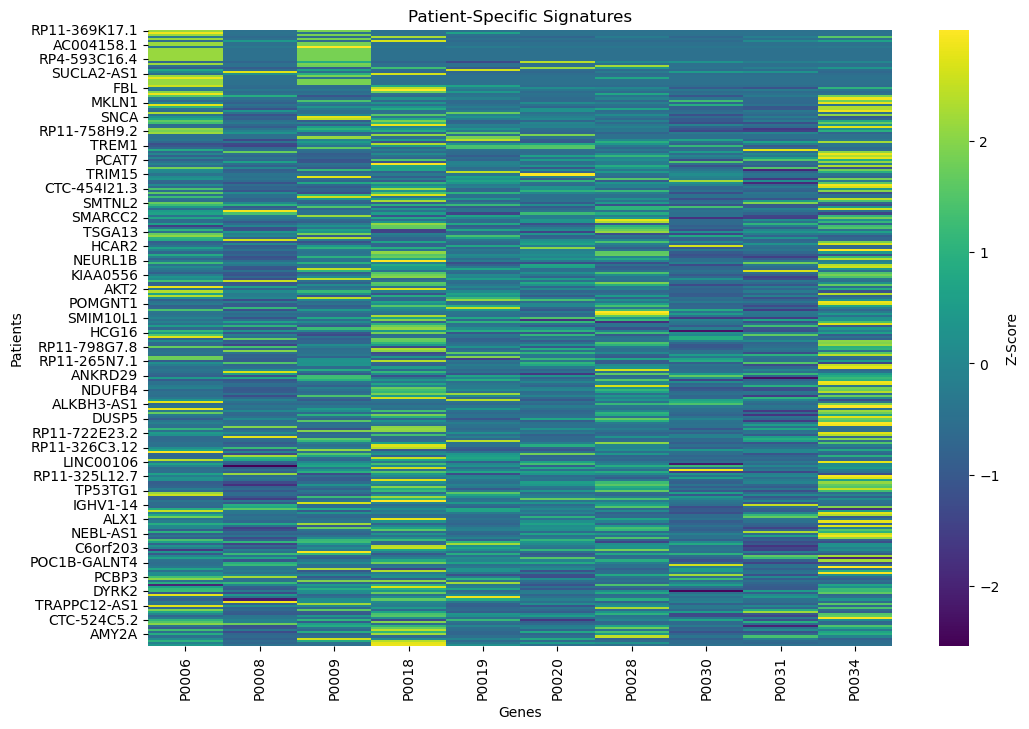

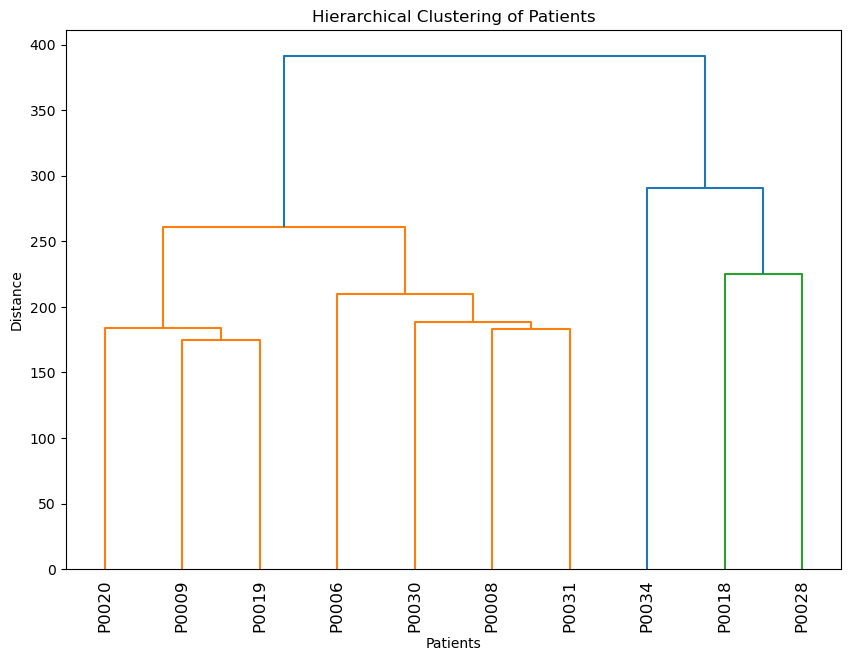

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram  # Import added here

# Load the dataset
data = pd.read_csv("combined_expression_data.csv")

# Step 1: Filter for Tumor Samples with "tLung"
data_filtered = data[
    (data['Patient_id'] != 'P0025') & 
    (data['Tissue_origin'].str.contains('tLung', na=False))  # Match 'tLung'
]

# Step 2: Select Gene Expression Columns
gene_expression_data = data_filtered.iloc[:, 10:]

# Fill missing values with the mean of each gene expression column
gene_expression_data.fillna(gene_expression_data.mean(), inplace=True)

# Normalize the gene expression data (Z-score normalization)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(gene_expression_data)
normalized_data = pd.DataFrame(normalized_data, columns=gene_expression_data.columns)

# Add Patient IDs
normalized_data['Patient_id'] = data_filtered['Patient_id'].values

# Step 3: Aggregate Data by Patient
patient_signatures = normalized_data.groupby('Patient_id').mean()

# Select Top Differential Genes
top_genes = patient_signatures.var().sort_values(ascending=False).index[:300]  # Top 300 most variable genes
patient_signatures_top = patient_signatures[top_genes]

# Step 4: Create a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(patient_signatures_top.T, cmap="viridis", annot=False, cbar_kws={'label': 'Z-Score'})
plt.title('Patient-Specific Signatures')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.xticks(rotation=90)
plt.show()

# Step 5: Perform Hierarchical Clustering 
linkage_matrix = linkage(patient_signatures, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=patient_signatures.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Patients')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

Initial clustering based on dendrogram

Start with finding the optimal threshold for clustering using silohuette score

In [4]:
# Find optimal threshold 
from sklearn.metrics import silhouette_score
import numpy as np
from scipy.cluster.hierarchy import fcluster

thresholds = np.linspace(10, 500, 30)  # Adjust as needed
best_threshold = None
best_score = -1

for threshold in thresholds:
    # Assign clusters
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    
    # Check number of clusters
    n_clusters = len(set(cluster_labels))
    if 2 <= n_clusters < len(patient_signatures_top):  # Valid range for silhouette score
        try:
            score = silhouette_score(patient_signatures_top, cluster_labels)
            print(f"Threshold: {threshold}, Clusters: {n_clusters}, Silhouette Score: {score}")
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        except ValueError as e:
            print(f"Threshold: {threshold}, Error: {e}")
    else:
        print(f"Threshold: {threshold}, Invalid number of clusters: {n_clusters}")

print(f"Best Distance Threshold: {best_threshold}, Best Silhouette Score: {best_score}")

Threshold: 10.0, Invalid number of clusters: 10
Threshold: 26.896551724137932, Invalid number of clusters: 10
Threshold: 43.793103448275865, Invalid number of clusters: 10
Threshold: 60.689655172413794, Invalid number of clusters: 10
Threshold: 77.58620689655173, Invalid number of clusters: 10
Threshold: 94.48275862068967, Invalid number of clusters: 10
Threshold: 111.37931034482759, Invalid number of clusters: 10
Threshold: 128.27586206896552, Invalid number of clusters: 10
Threshold: 145.17241379310346, Invalid number of clusters: 10
Threshold: 162.0689655172414, Invalid number of clusters: 10
Threshold: 178.96551724137933, Clusters: 9, Silhouette Score: -0.015472256527192325
Threshold: 195.86206896551727, Clusters: 6, Silhouette Score: 0.05439824610066788
Threshold: 212.75862068965517, Clusters: 5, Silhouette Score: 0.026664226580996524
Threshold: 229.6551724137931, Clusters: 4, Silhouette Score: 0.03462952526281461
Threshold: 246.55172413793105, Clusters: 4, Silhouette Score: 0.034

Optimal threshold appears to be 300, so use that to set the clusters and then plot display which patient belongs to which cluster 

            Cluster
Patient_id         
P0006             1
P0008             1
P0009             1
P0018             2
P0019             1
P0020             1
P0028             2
P0030             1
P0031             1
P0034             2


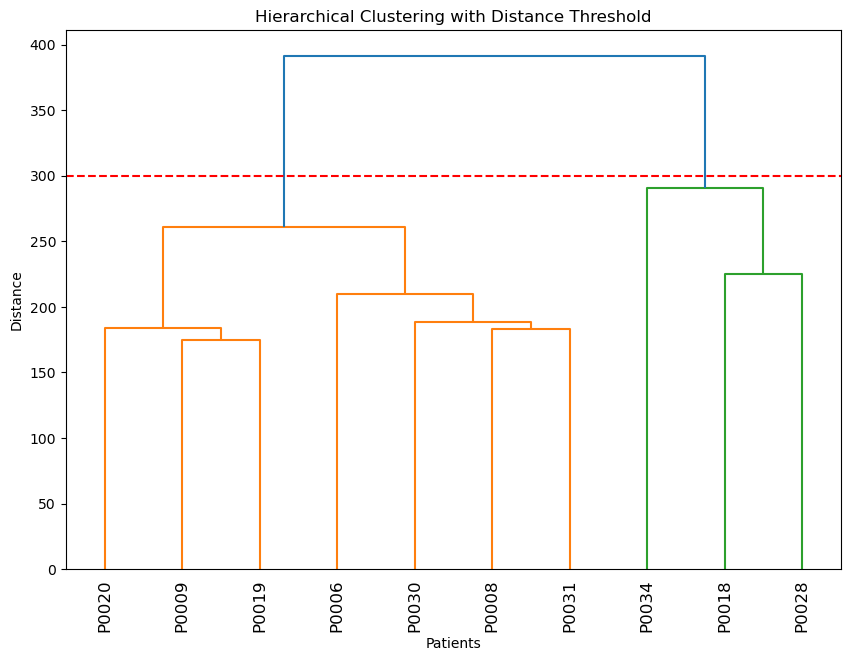

Silhouette Score: 0.19542666081571822


In [6]:
from scipy.cluster.hierarchy import fcluster

# Set a distance threshold from the dendrogram (e.g., the height where you see natural clusters)
distance_threshold = 300  # Played with this value, this level gives highest silohuette score

# Assign clusters based on the distance threshold
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Add cluster assignments to the patient signatures DataFrame
patient_signatures['Cluster'] = cluster_labels

# Display cluster assignments
print(patient_signatures[['Cluster']])

# Re-plot dendrogram with labels
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=patient_signatures.index, leaf_rotation=90, color_threshold=distance_threshold)
plt.axhline(y=distance_threshold, color='r', linestyle='--')  # Show threshold
plt.title('Hierarchical Clustering with Distance Threshold')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

# Validate number of clusters
from sklearn.metrics import silhouette_score

# Calculate silhouette score (requires a distance matrix)
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(patient_signatures.iloc[:, :-1]))  # Exclude cluster column

# Compute silhouette score
sil_score = silhouette_score(distance_matrix, cluster_labels, metric="precomputed")
print(f'Silhouette Score: {sil_score}')

Display a heatmap of resulting clusters

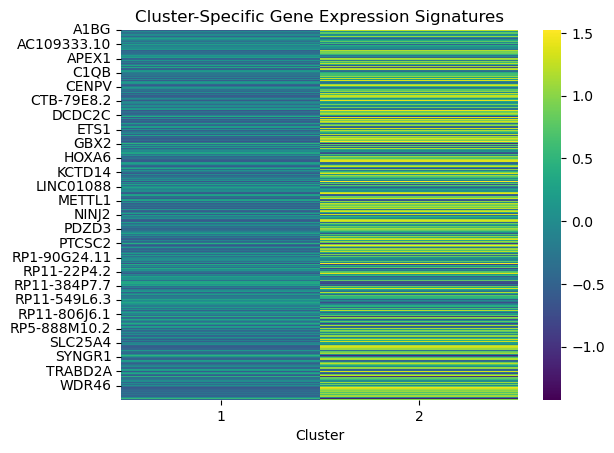

In [275]:
cluster_means = patient_signatures.groupby('Cluster').mean()
sns.heatmap(cluster_means.T, cmap='viridis', annot=False)
plt.title('Cluster-Specific Gene Expression Signatures')
plt.show()

Find the statistically significant differential genes between tumor samples

In [277]:
from scipy.stats import f_oneway
import pandas as pd
import numpy as np

# Step 1: Prepare Data
# Assume `patient_signatures_top` contains gene expression data for the top genes
# and `patient_signatures['Cluster']` has the cluster labels.

clusters = patient_signatures['Cluster'].unique()  # Get unique cluster labels
gene_expression_data = patient_signatures_top  # Subset containing only gene expression

# Step 2: Perform ANOVA for Each Gene
anova_results = []
for gene in gene_expression_data.columns:
    # Extract expression values for each cluster
    cluster_values = [gene_expression_data[patient_signatures['Cluster'] == cluster][gene] for cluster in clusters]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*cluster_values)
    anova_results.append({'Gene': gene, 'F-statistic': f_stat, 'P-value': p_value})

# Step 3: Create Results DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Step 4: Adjust P-Values for Multiple Testing (Benjamini-Hochberg)
from statsmodels.stats.multitest import multipletests

anova_results_df['Adjusted P-value'] = multipletests(anova_results_df['P-value'], method='fdr_bh')[1]

# Step 5: Filter Significant Genes
significant_genes = anova_results_df[anova_results_df['Adjusted P-value'] < 0.05]
print(f"Number of significant genes: {len(significant_genes)}")
print(significant_genes)

Number of significant genes: 52
               Gene  F-statistic   P-value  Adjusted P-value
38             PBX2    18.823241  0.002483          0.031835
41             NEK9    15.155291  0.004590          0.044421
66            MLLT6    20.083006  0.002052          0.027787
87           LMNTD2    20.068850  0.002056          0.027787
93             NET1    18.264516  0.002711          0.032360
95      RP11-7O11.3    23.288147  0.001312          0.020495
96              AHR   113.688593  0.000005          0.001312
103            ELF3    21.803819  0.001604          0.023583
108         CABLES2    30.415830  0.000564          0.012810
111       KIAA0319L    17.731318  0.002952          0.033550
118            AGRN    76.418898  0.000023          0.002294
119        KIAA0556    18.246673  0.002718          0.032360
124          ELAVL1    25.355998  0.001007          0.017987
152           TRPT1   174.947686  0.000001          0.000509
174             PML    19.781407  0.002146          0

Display heatmap of results

/var/folders/2b/yg1lrv3s0_ldgyw5yrqp5qvr9gsw6g/T/ipykernel_93453/2014451860.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Cluster'] = patient_signatures['Cluster']


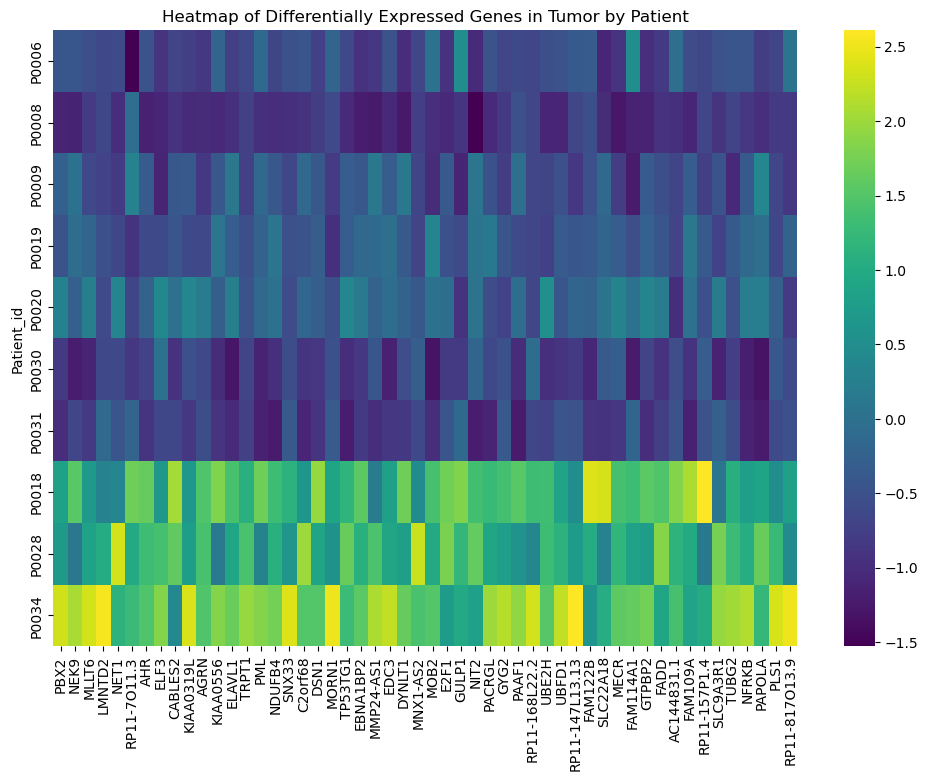

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset data for significant genes
significant_gene_names = significant_genes['Gene']
heatmap_data = patient_signatures_top[significant_gene_names]

# Add cluster labels for sorting
heatmap_data['Cluster'] = patient_signatures['Cluster']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.sort_values('Cluster').drop('Cluster', axis=1), cmap='viridis')
plt.title('Heatmap of Differentially Expressed Genes in Tumor by Patient')
plt.show()

Find cluster-specific differential expression genes

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Cluster 1 Significant DEGs:
            Gene  Fold Change  T-statistic  Adjusted P-value
95   RP11-7O11.3    -1.882643    -5.983554          0.038175
96           AHR    -2.109230   -14.095560          0.000515
118         AGRN    -2.076208   -13.670957          0.001598
124       ELAVL1    -1.902584    -6.103930          0.038296
175       NDUFB4    -1.975731    -7.305406          0.017827
224      TP53TG1    -1.959808    -7.785079          0.005127
243     EBNA1BP2    -2.005581    -8.420889          0.005127
284         MOB2    -1.849631    -6.263077          0.017457
348        UBE2H    -1.985468    -9.414209          0.003784
399         MECR    -1.981634    -8.604767          0.003784
Cluster 2 Significant DEGs:
            Gene  Fold Change  T-statistic  Adjusted P-value
595  RP11-7O11.3     1.882643     5.983554          0.038175
596          AHR     2.109230    14.095560          0.000515
618         AGRN     2.076208    13.670957          0.001598
624       ELAVL1     1.902584

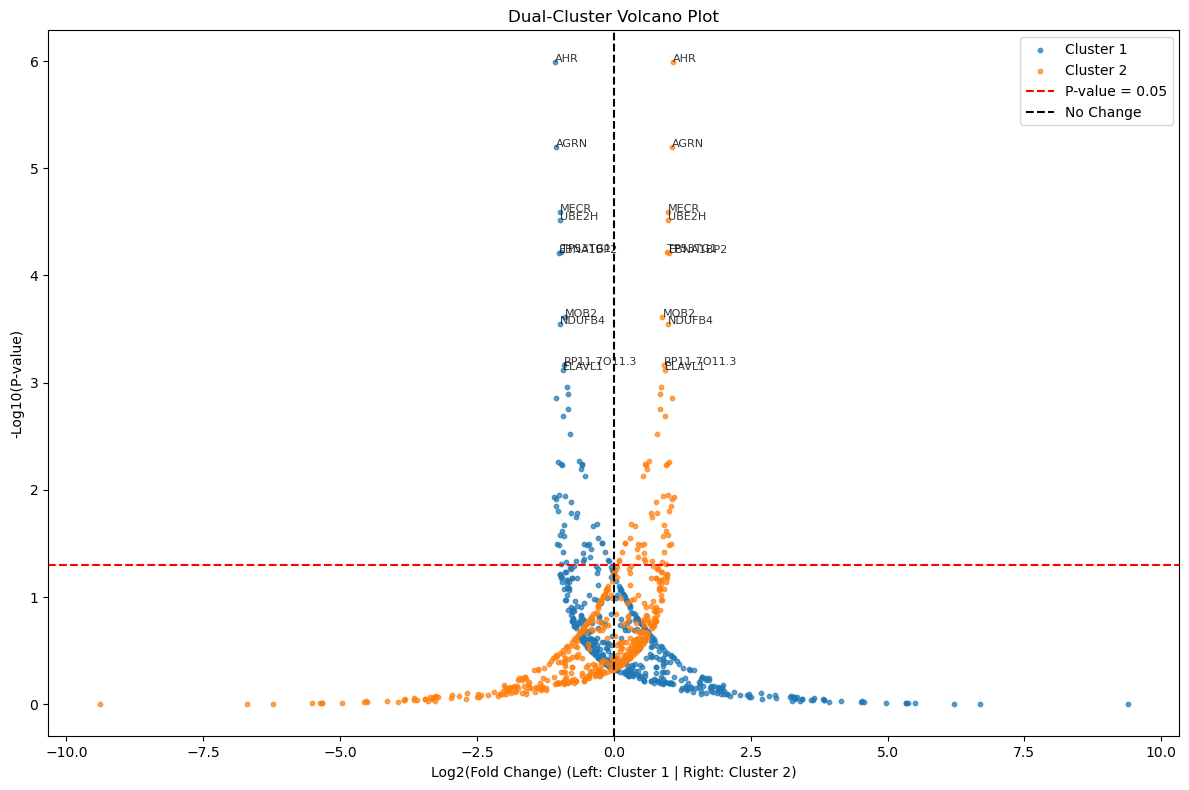

In [281]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Step 1: Prepare Data
clusters = patient_signatures['Cluster'].unique()  # Unique cluster labels
gene_expression_data = patient_signatures_top  # Subset with only gene expression data

# Step 2: Initialize Results
deg_results = []

# Step 3: Perform Differential Expression Analysis for Each Cluster
for cluster in clusters:
    cluster_genes = gene_expression_data[patient_signatures['Cluster'] == cluster]
    other_genes = gene_expression_data[patient_signatures['Cluster'] != cluster]
    
    for gene in gene_expression_data.columns:
        # Perform t-test
        t_stat, p_value = ttest_ind(cluster_genes[gene], other_genes[gene], equal_var=False)
        
        # Calculate fold change
        fold_change = cluster_genes[gene].mean() - other_genes[gene].mean()
        
        # Save results
        deg_results.append({
            'Gene': gene,
            'Cluster': cluster,
            'T-statistic': t_stat,
            'Fold Change': fold_change,
            'P-value': p_value
        })

# Step 4: Create Results DataFrame
deg_df = pd.DataFrame(deg_results)

# Step 5: Adjust P-values for Multiple Testing
deg_df['Adjusted P-value'] = multipletests(deg_df['P-value'], method='fdr_bh')[1]

# Step 6: Add Log-Transformed Values and Significant Indicators
deg_df['-log10(P-value)'] = -np.log10(deg_df['P-value'])
deg_df['log2(Fold Change)'] = np.log2(deg_df['Fold Change'].replace(0, np.nan).abs())
deg_df['Significant'] = deg_df['Adjusted P-value'] < 0.05

# Report significant DEGs for each cluster
for cluster in clusters:
    cluster_degs = deg_df[(deg_df['Cluster'] == cluster) & (deg_df['Significant'])]
    print(f"Cluster {cluster} Significant DEGs:")
    print(cluster_degs[['Gene', 'Fold Change', 'T-statistic', 'Adjusted P-value']])

# Step 7: Create Dual-Cluster Volcano Plot
plt.figure(figsize=(12, 8))

# Plot data for each cluster
for cluster in clusters:
    cluster_data = deg_df[deg_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['log2(Fold Change)'] * (-1 if cluster == clusters[0] else 1),  # Invert fold change for left cluster
        cluster_data['-log10(P-value)'], 
        alpha=0.7, label=f'Cluster {cluster}', s=10
    )

# Highlight significant points with labels
for cluster in clusters:
    significant_data = deg_df[(deg_df['Cluster'] == cluster) & (deg_df['Significant'])]
    for i, row in significant_data.iterrows():
        x_pos = row['log2(Fold Change)'] * (-1 if cluster == clusters[0] else 1)
        y_pos = row['-log10(P-value)']
        plt.text(x_pos, y_pos, row['Gene'], fontsize=8, alpha=0.8)

# Add horizontal significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='P-value = 0.05')

# Add vertical no-change line
plt.axvline(x=0, color='black', linestyle='--', label='No Change')

# Customize plot
plt.title('Dual-Cluster Volcano Plot')
plt.xlabel('Log2(Fold Change) (Left: Cluster 1 | Right: Cluster 2)')
plt.ylabel('-Log10(P-value)')
plt.legend()
plt.tight_layout()
plt.show()

The gene sets are the same with downregulation in cluster 1, upregulation in cluster 2

Create a heatmap to visualize the results

/var/folders/2b/yg1lrv3s0_ldgyw5yrqp5qvr9gsw6g/T/ipykernel_93453/3187177753.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Cluster'] = patient_signatures['Cluster']


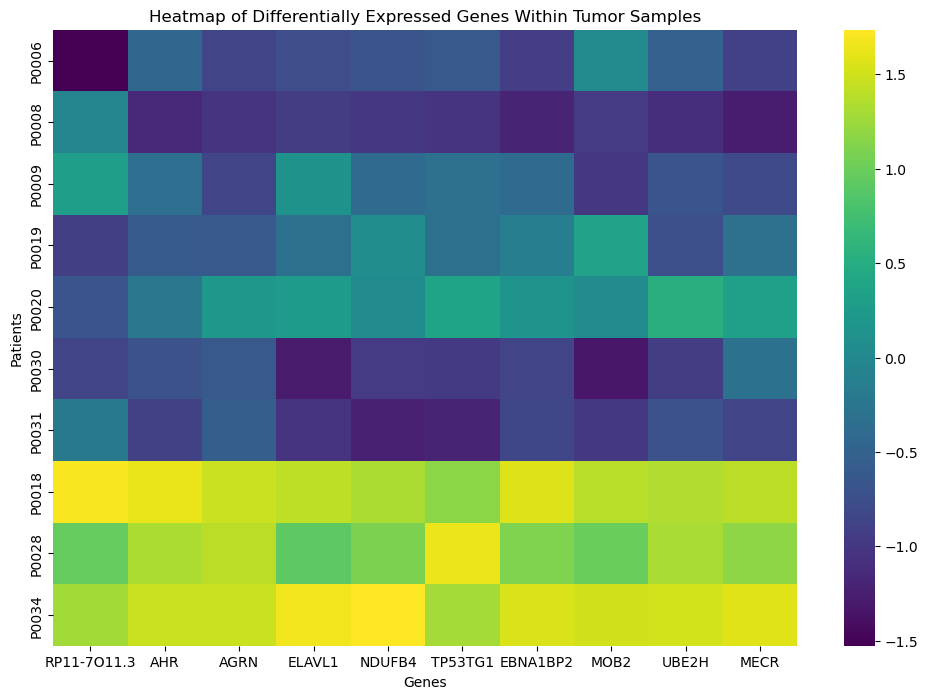

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for significant DEGs
significant_genes = significant_degs['Gene'].unique()
heatmap_data = patient_signatures_top[significant_genes]

# Add cluster labels
heatmap_data['Cluster'] = patient_signatures['Cluster']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.sort_values('Cluster').drop('Cluster', axis=1), cmap='viridis')
plt.title('Heatmap of Differentially Expressed Genes Within Tumor Samples')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

In [135]:
# Save to CSV
for cluster in clusters:
    cluster_degs = significant_degs[significant_degs['Cluster'] == cluster]
    cluster_genes = cluster_degs['Gene']
    cluster_genes.to_csv(f'h_cluster_{cluster}_degs.txt', index=False, header=False)

Look at characteristics of patients in each cluster

In [177]:
import pandas as pd
from scipy.stats import chi2_contingency

# Step 1: Load Data
data = pd.read_csv("combined_expression_data.csv")

# Step 2: Filter for tLung Tissue Origin
data_tlung = data[data['Tissue_origin'] == 'tLung']

# Step 3: Ensure Clusters Are Mapped to Patients
# Assuming `patient_signatures` contains clusters with 'Patient_id' as an index
cluster_assignments = patient_signatures[['Cluster']].reset_index()  # Reset index to access Patient_id
data_tlung = pd.merge(data_tlung, cluster_assignments, on='Patient_id', how='inner')  # Merge clusters with metadata

# Step 4: Select Metadata Columns for Analysis
metadata_columns = ['Sex', 'Smoking', 'Stage']
metadata = data_tlung[metadata_columns + ['Cluster']]

# Step 5: Calculate Category Proportions by Cluster
for column in metadata_columns:
    # Group by Cluster and calculate proportions
    proportions = metadata.groupby(['Cluster', column]).size().unstack(fill_value=0)
    proportions = proportions.apply(lambda x: x / x.sum(), axis=1)  # Convert to proportions

    print(f"\nProportion Breakdown for {column} by Cluster:")
    print(proportions)

# Step 6: Perform Statistical Tests for Each Metadata Attribute
results = []
for column in metadata_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(metadata[column], metadata['Cluster'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Append results
    results.append({
        'Attribute': column,
        'Chi-Square Statistic': chi2,
        'P-value': p_value
    })

# Create a DataFrame with Results
results_df = pd.DataFrame(results)

# Display Results
print("\nStatistical Test Results for Metadata Attributes:")
print(results_df)

# Highlight Significant Attributes
significant_attributes = results_df[results_df['P-value'] < 0.05]
print("\nSignificant Metadata Attributes:")
print(significant_attributes)


Proportion Breakdown for Sex by Cluster:
Sex      Male
Cluster      
1         1.0
2         1.0

Proportion Breakdown for Smoking by Cluster:
Smoking       Cur        Ex     Never
Cluster                              
1        0.285714  0.428571  0.285714
2        0.333333  0.333333  0.333333

Proportion Breakdown for Stage by Cluster:
Stage          IA       IA3        IB       IIA      IIIA
Cluster                                                  
1        0.571429  0.000000  0.142857  0.142857  0.142857
2        0.333333  0.333333  0.000000  0.000000  0.333333

Statistical Test Results for Metadata Attributes:
  Attribute  Chi-Square Statistic   P-value
0       Sex              0.000000  1.000000
1   Smoking              0.079365  0.961095
2     Stage              3.809524  0.432397

Significant Metadata Attributes:
Empty DataFrame
Columns: [Attribute, Chi-Square Statistic, P-value]
Index: []


# Patient Specific Signatures
Looking at not just differences between tumors but if there are common changes from normal

Take the combined data, pair normal and tumor for each patient and calculate difference between the paired values for each patient, representing change from normal to tumor state.

Columns of paired_data: MultiIndex([(        'A1BG', 'nLung'),
            (        'A1BG', 'tLung'),
            (    'A1BG-AS1', 'nLung'),
            (    'A1BG-AS1', 'tLung'),
            (        'A1CF', 'nLung'),
            (        'A1CF', 'tLung'),
            (         'A2M', 'nLung'),
            (         'A2M', 'tLung'),
            (     'A2M-AS1', 'nLung'),
            (     'A2M-AS1', 'tLung'),
            ...
            (         'ZYX', 'nLung'),
            (         'ZYX', 'tLung'),
            (       'ZZEF1', 'nLung'),
            (       'ZZEF1', 'tLung'),
            (        'ZZZ3', 'nLung'),
            (        'ZZZ3', 'tLung'),
            ('bP-21264C1.2', 'nLung'),
            ('bP-21264C1.2', 'tLung'),
            ( 'bP-2189O9.3', 'nLung'),
            ( 'bP-2189O9.3', 'tLung')],
           names=[None, 'Tissue_origin'], length=59268)


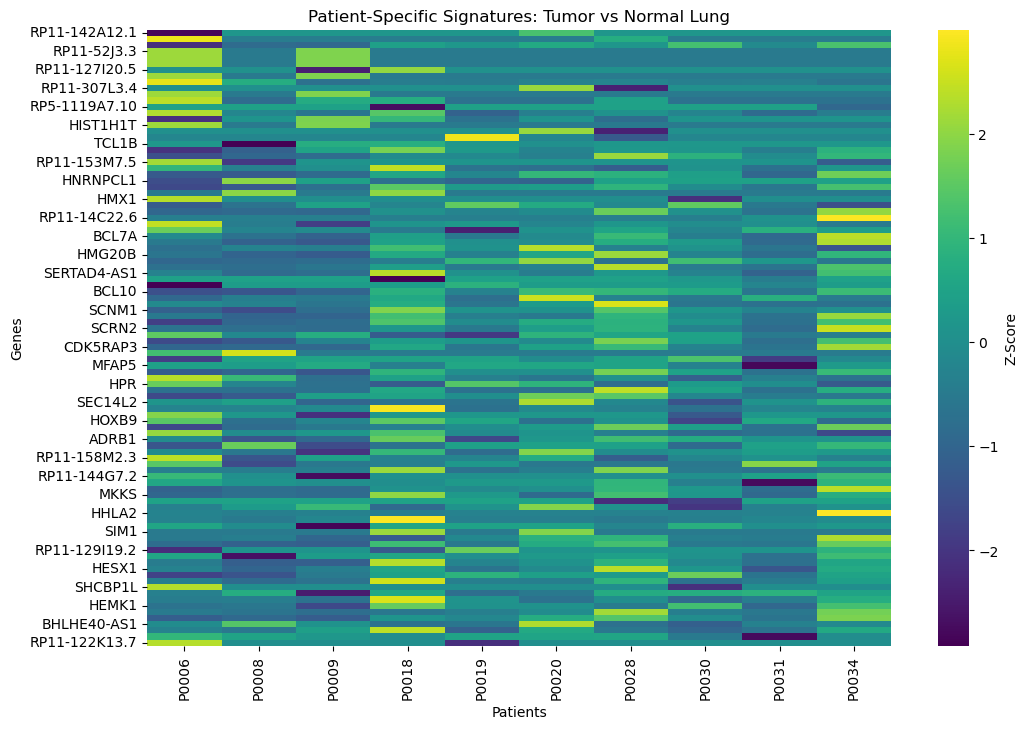

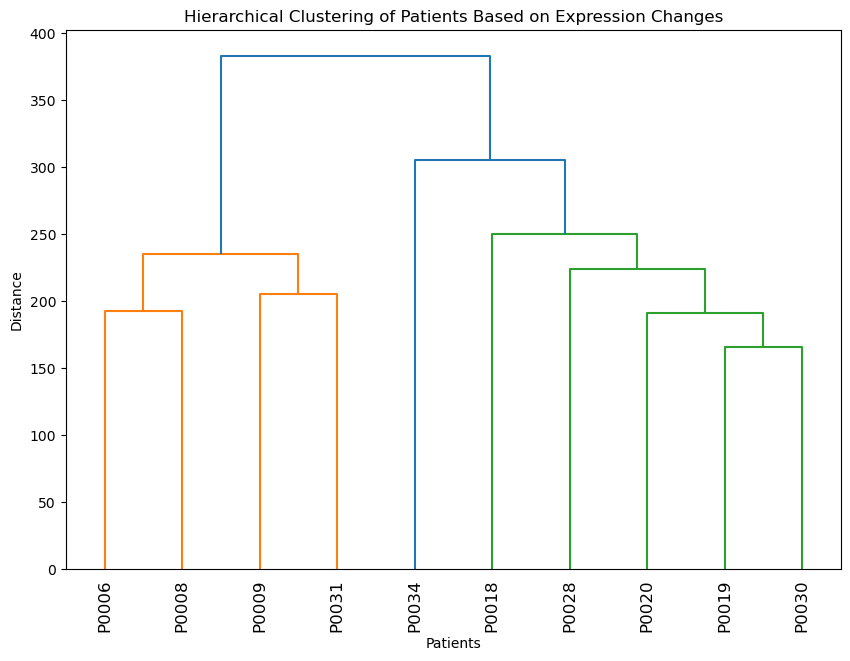

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the dataset
data = pd.read_csv("combined_expression_data.csv")

# Step 1: Filter for Relevant Samples (nLung and tLung)
data_filtered = data[data['Tissue_origin'].str.contains('nLung|tLung', na=False)]

# Step 2: Ensure Pairing of nLung and tLung for Each Patient
paired_data = data_filtered.pivot_table(
    index='Patient_id',
    columns='Tissue_origin',
    values=data_filtered.columns[10:],  # Gene expression columns
    aggfunc='mean'
)

# Debugging: Print column structure
print("Columns of paired_data:", paired_data.columns)

# Adjust column access to fit the actual structure
nlung_columns = [col for col in paired_data.columns if 'nLung' in col]
tlung_columns = [col for col in paired_data.columns if 'tLung' in col]

# Drop patients without both `nLung` and `tLung`
paired_data = paired_data.dropna(subset=nlung_columns, how='any')
paired_data = paired_data.dropna(subset=tlung_columns, how='any')

# Step 3: Calculate Changes in Expression (tLung - nLung)
expression_change = paired_data[tlung_columns].droplevel(level=1, axis=1) - \
                    paired_data[nlung_columns].droplevel(level=1, axis=1)

# Step 4: Normalize the Data (Z-score normalization)
scaler = StandardScaler()
normalized_changes = scaler.fit_transform(expression_change)
normalized_changes = pd.DataFrame(normalized_changes, index=expression_change.index, columns=expression_change.columns)

# Step 5: Select Top Differential Genes 
top_genes = normalized_changes.var().sort_values(ascending=False).index[:100]  # Top 500 most variable genes
normalized_changes_top = normalized_changes[top_genes]

# Step 6: Create a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_changes_top.T, cmap="viridis", annot=False, cbar_kws={'label': 'Z-Score'})
plt.title('Patient-Specific Signatures: Tumor vs Normal Lung')
plt.xlabel('Patients')
plt.ylabel('Genes')
plt.xticks(rotation=90)
plt.show()

# Step 7: Perform Hierarchical Clustering 
linkage_matrix = linkage(normalized_changes, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=normalized_changes.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Patients Based on Expression Changes')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

Calculate optimal threshold for clustering

In [24]:
from sklearn.metrics import silhouette_score
import numpy as np
from scipy.cluster.hierarchy import fcluster

# Generate the linkage matrix for hierarchical clustering
linkage_matrix = linkage(normalized_changes, method='ward')

# Define thresholds to test
thresholds = np.linspace(10, 500, 30)  # Adjust range and steps as needed
best_threshold = None
best_score = -1

# Iterate through thresholds to find the best one
for threshold in thresholds:
    # Assign clusters based on the current threshold
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    
    # Check the number of clusters
    n_clusters = len(set(cluster_labels))
    if 2 <= n_clusters < len(normalized_changes):  # Valid range for silhouette score
        try:
            # Calculate the silhouette score
            score = silhouette_score(normalized_changes, cluster_labels)
            print(f"Threshold: {threshold}, Clusters: {n_clusters}, Silhouette Score: {score}")
            
            # Update the best score and threshold if the current score is better
            if score > best_score:
                best_score = score
                best_threshold = threshold
        except ValueError as e:
            print(f"Threshold: {threshold}, Error: {e}")
    else:
        print(f"Threshold: {threshold}, Invalid number of clusters: {n_clusters}")

print(f"Best Distance Threshold: {best_threshold}, Best Silhouette Score: {best_score}")

Threshold: 10.0, Invalid number of clusters: 10
Threshold: 26.896551724137932, Invalid number of clusters: 10
Threshold: 43.793103448275865, Invalid number of clusters: 10
Threshold: 60.689655172413794, Invalid number of clusters: 10
Threshold: 77.58620689655173, Invalid number of clusters: 10
Threshold: 94.48275862068967, Invalid number of clusters: 10
Threshold: 111.37931034482759, Invalid number of clusters: 10
Threshold: 128.27586206896552, Invalid number of clusters: 10
Threshold: 145.17241379310346, Invalid number of clusters: 10
Threshold: 162.0689655172414, Invalid number of clusters: 10
Threshold: 178.96551724137933, Clusters: 9, Silhouette Score: 0.020549396358745736
Threshold: 195.86206896551727, Clusters: 7, Silhouette Score: 0.04685774425838511
Threshold: 212.75862068965517, Clusters: 6, Silhouette Score: 0.059593357057236576
Threshold: 229.6551724137931, Clusters: 5, Silhouette Score: 0.0677100791876791
Threshold: 246.55172413793105, Clusters: 4, Silhouette Score: 0.08981

Apply that optimal threshold and assign clusters

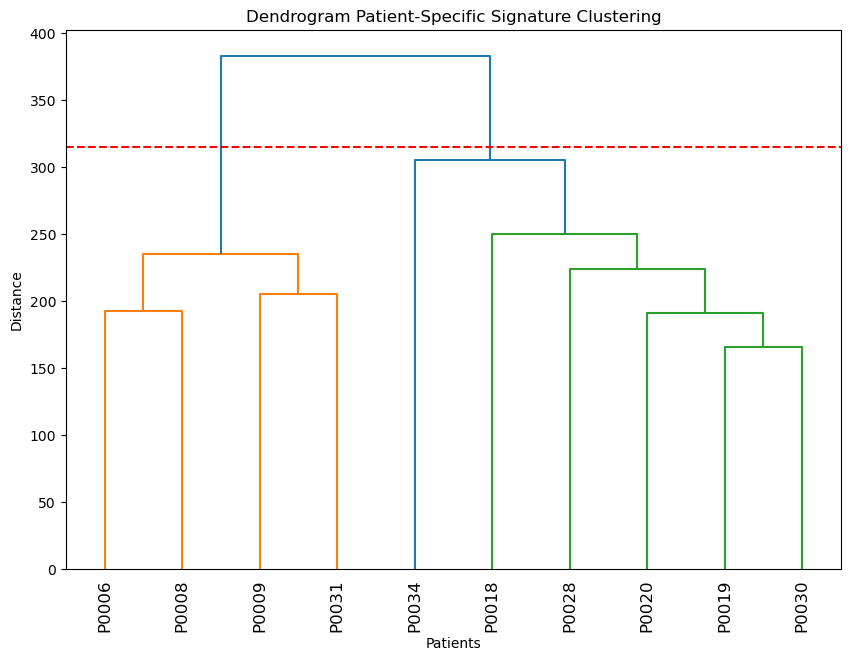

In [64]:
from scipy.cluster.hierarchy import fcluster

# Generate the linkage matrix
linkage_matrix = linkage(normalized_changes, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=normalized_changes.index, leaf_rotation=90)
plt.title('Dendrogram Patient-Specific Signature Clustering')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.axhline(y=315, color='r', linestyle='--')  # Example threshold
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


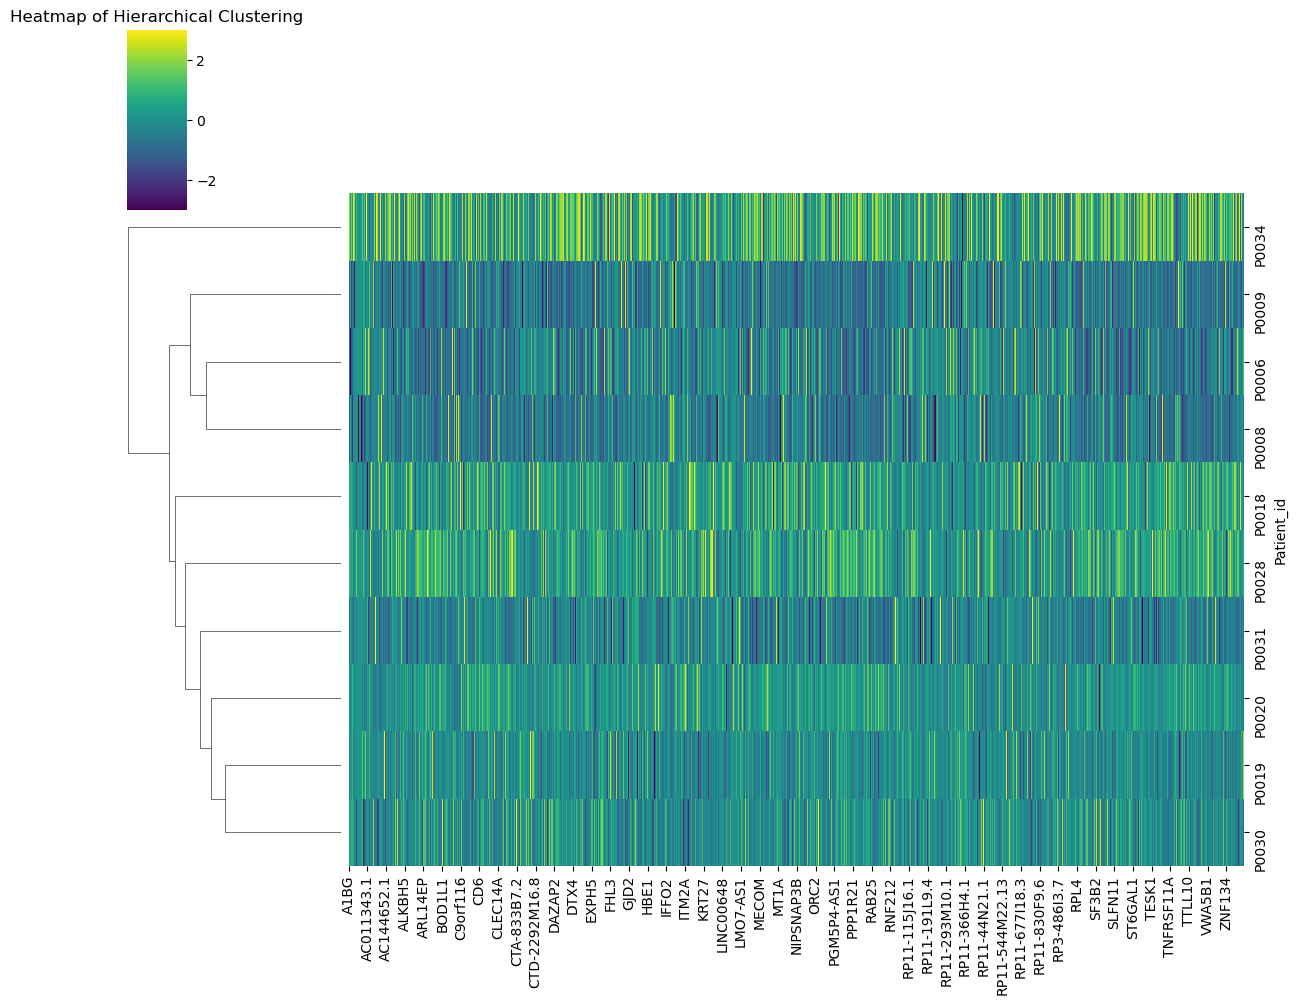

In [36]:
from scipy.cluster.hierarchy import fcluster

# Assign clusters based on the optimal threshold
optimal_clusters = fcluster(linkage_matrix, best_threshold, criterion='distance')

# Add clusters to the data for further analysis or visualization
normalized_changes['Cluster'] = optimal_clusters

# Example visualization
sns.clustermap(
    normalized_changes.drop(columns=['Cluster']),
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,
    figsize=(12, 10)
)
plt.title('Heatmap of Hierarchical Clustering')
plt.show()

Cluster Assignment Summary:
Cluster
2    6
1    4
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


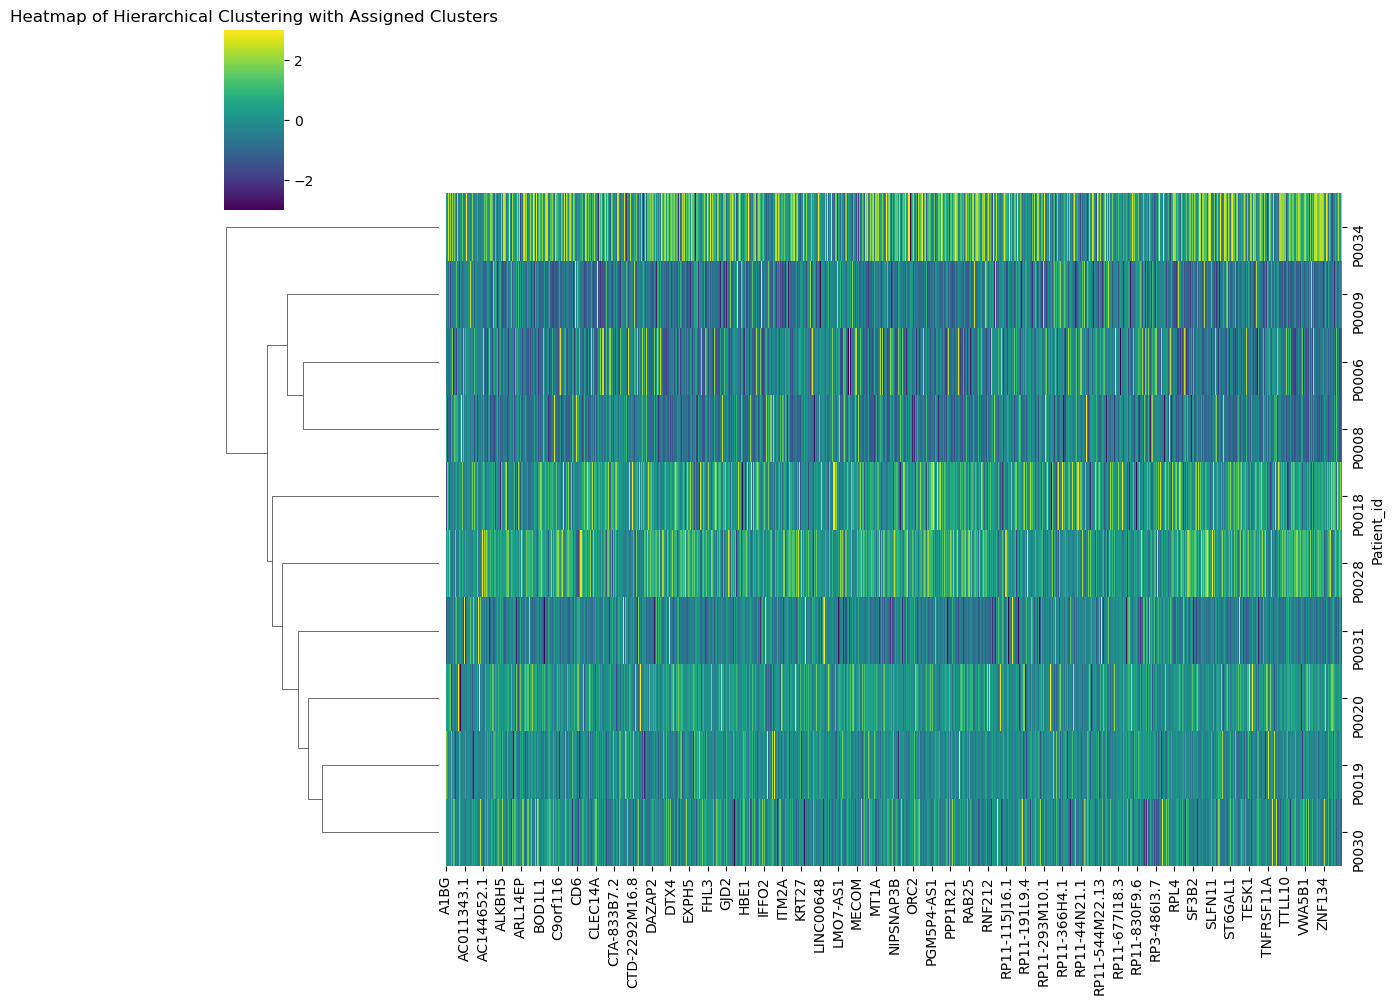

Top 10 genes with largest differences in mean expression:
RP11-95I16.2    1.954041
OR2A1-AS1       1.949616
CMPK1           1.937309
YWHAE           1.928274
ATP5L           1.926732
TAF13           1.925134
NXT2            1.923145
LSM4            1.921697
AGFG1           1.919571
AC004381.6      1.917172
dtype: float64


In [48]:
# Ensure required imports
from scipy.cluster.hierarchy import fcluster

# Perform clustering using the best threshold
if best_threshold:
    optimal_clusters = fcluster(linkage_matrix, best_threshold, criterion='distance')

    # Add the clusters to the DataFrame
    normalized_changes['Cluster'] = optimal_clusters

    # Check assignment summary
    print("Cluster Assignment Summary:")
    print(normalized_changes['Cluster'].value_counts())

    # Visualize the heatmap with assigned clusters
    sns.clustermap(
        normalized_changes.drop(columns=['Cluster']),
        cmap="viridis",
        row_cluster=True,
        col_cluster=False,
        figsize=(12, 10)
    )
    plt.title('Heatmap of Hierarchical Clustering with Assigned Clusters')
    plt.show()
else:
    print("No valid threshold found for assigning clusters.")

# Define clusters after assignment
cluster_1 = normalized_changes[normalized_changes['Cluster'] == 1].drop(columns=['Cluster'])
cluster_2 = normalized_changes[normalized_changes['Cluster'] == 2].drop(columns=['Cluster'])

# Calculate mean expression values for each cluster
mean_cluster_1 = cluster_1.mean()
mean_cluster_2 = cluster_2.mean()

# Compute absolute differences between clusters
mean_diff = (mean_cluster_1 - mean_cluster_2).abs()

# Display top genes with the largest differences
top_diff_genes = mean_diff.sort_values(ascending=False).head(10)
print("Top 10 genes with largest differences in mean expression:")
print(top_diff_genes)

Inspect for genes with differential expression p value < 0.05

In [50]:
from scipy.stats import ttest_ind

# Initialize results list
results = []

# Perform t-tests between clusters (assuming two clusters)
for gene in normalized_changes_top.columns:
    cluster_1_values = normalized_changes_top.loc[normalized_changes['Cluster'] == 1, gene]
    cluster_2_values = normalized_changes_top.loc[normalized_changes['Cluster'] == 2, gene]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(cluster_1_values, cluster_2_values, equal_var=False)
    results.append({
        'Gene': gene,
        't_stat': t_stat,
        'p_value': p_value
    })

# Create DataFrame from results
results = pd.DataFrame(results)

# Inspect significant genes
raw_significant_genes = results[results['p_value'] < 0.05]
print("Number of raw significant genes:", len(raw_significant_genes))
print(raw_significant_genes)

# Inspect raw p-values
raw_significant_genes = results[results['p_value'] < 0.05]
print("Number of raw significant genes:", len(raw_significant_genes))
print(raw_significant_genes)

# Calculate mean expression values for each cluster
mean_cluster_1 = cluster_1.mean()
mean_cluster_2 = cluster_2.mean()

# Compute absolute differences between clusters
mean_diff = (mean_cluster_1 - mean_cluster_2).abs()

# Display top genes with the largest differences
top_diff_genes = mean_diff.sort_values(ascending=False).head(10)
print("Top 10 genes with largest differences in mean expression:")
print(top_diff_genes)

Number of raw significant genes: 25
           Gene    t_stat   p_value
2         RAB8A -3.627514  0.018483
20         MGMT -2.905101  0.019737
23      HNRNPDL -6.461545  0.000496
25      HNRNPAB -5.109943  0.001047
29        HOOK3 -3.493575  0.015904
34        MIER3 -4.022554  0.005228
36       HMG20B -3.946846  0.007183
39  SERTAD4-AS1 -2.749294  0.031980
42        BCL10 -6.285578  0.000274
45        SCNM1 -3.666808  0.006386
46         HSCB -3.084501  0.021953
47         BBS7 -5.275063  0.001108
48        SCRN2 -2.952266  0.030978
50        HSBP1 -3.916549  0.004977
51     CDK5RAP3 -3.541272  0.014663
55          MFF -5.646078  0.000742
64       SEC61B -3.593722  0.007230
74        SETD7 -3.798472  0.011481
75         MKKS -3.698410  0.013384
83          HGS -3.796156  0.008687
86         SKP2 -3.375695  0.012732
87        HESX1 -2.599599  0.033141
88         MITF -4.885914  0.003014
93        HEMK1 -3.861009  0.004886
95        MKRN1 -4.515132  0.003458
Number of raw significant ge

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Take difference in mean expression for each gene between clusters, perform t-tests on each gene, and generate a volcano plot using a fold change threshold of 1 and p value threshold of 0.5 

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


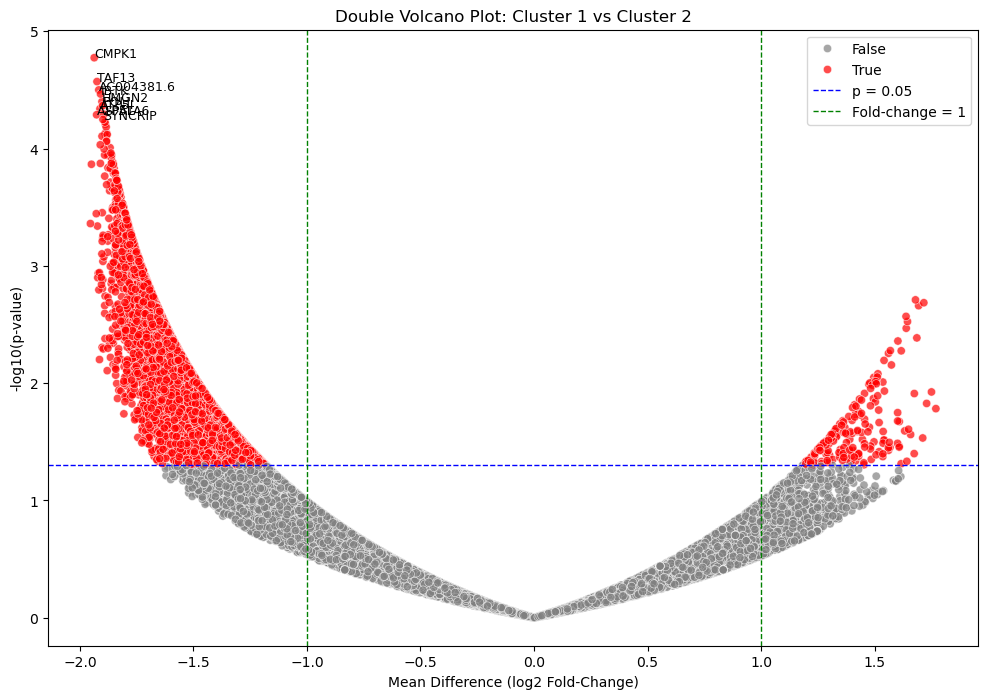

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Compute mean expression differences
mean_diff = cluster_1.mean() - cluster_2.mean()

# Perform t-tests for each gene
p_values = []
for gene in cluster_1.columns:
    stat, p = ttest_ind(cluster_1[gene], cluster_2[gene], equal_var=False)  # Welch's t-test
    p_values.append(p)

# Convert p-values to -log10(p-value)
log_p_values = -np.log10(p_values)

# Create a DataFrame for plotting
volcano_df = pd.DataFrame({
    'Gene': cluster_1.columns,
    'Mean_Difference': mean_diff,
    'Log_P_Value': log_p_values,
    'P_Value': p_values
})

# Set thresholds for significance
fc_threshold = 1  # Fold-change threshold
pval_threshold = 0.05

# Classify genes
volcano_df['Significant'] = (
    (volcano_df['P_Value'] < pval_threshold) &
    (abs(volcano_df['Mean_Difference']) > fc_threshold)
)

# Annotate top genes
top_genes = volcano_df.nsmallest(10, 'P_Value')  # Top 10 genes by p-value

# Plot the double volcano plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Mean_Difference',
    y='Log_P_Value',
    hue='Significant',
    data=volcano_df,
    palette={True: 'red', False: 'gray'},
    alpha=0.7
)

# Add annotations for top genes
for _, row in top_genes.iterrows():
    plt.text(
        row['Mean_Difference'],
        row['Log_P_Value'],
        row['Gene'],
        fontsize=9,
        ha='right' if row['Mean_Difference'] > 0 else 'left'
    )

# Add labels and title
plt.axhline(-np.log10(pval_threshold), color='blue', linestyle='--', linewidth=1, label=f'p = {pval_threshold}')
plt.axvline(fc_threshold, color='green', linestyle='--', linewidth=1, label=f'Fold-change = {fc_threshold}')
plt.axvline(-fc_threshold, color='green', linestyle='--', linewidth=1)
plt.title('Double Volcano Plot: Cluster 1 vs Cluster 2')
plt.xlabel('Mean Difference (log2 Fold-Change)')
plt.ylabel('-log10(p-value)')
plt.legend()
plt.show()

List top upregulated genes in each cluster

In [54]:
# Define thresholds
fc_threshold = 1  # Fold-change threshold
pval_threshold = 0.05  # P-value threshold

# Filter significant genes
significant_genes = volcano_df[
    (volcano_df['P_Value'] < pval_threshold) &
    (abs(volcano_df['Mean_Difference']) > fc_threshold)
]

# Separate upregulated genes by cluster
upregulated_cluster_1 = significant_genes[significant_genes['Mean_Difference'] > 0]
upregulated_cluster_2 = significant_genes[significant_genes['Mean_Difference'] < 0]

# Get top 20 genes for each cluster
top_20_cluster_1 = upregulated_cluster_1.nlargest(20, 'Mean_Difference')
top_20_cluster_2 = upregulated_cluster_2.nsmallest(20, 'Mean_Difference')  # Use nsmallest for negative differences

# Display results
print("Top 20 Upregulated Genes in Cluster 1:")
print(top_20_cluster_1[['Gene', 'Mean_Difference', 'P_Value']])

print("\nTop 20 Upregulated Genes in Cluster 2:")
print(top_20_cluster_2[['Gene', 'Mean_Difference', 'P_Value']])

# Save to CSV
top_20_cluster_1.to_csv("top_20_upregulated_cluster_1.csv", index=False)
top_20_cluster_2.to_csv("top_20_upregulated_cluster_2.csv", index=False)

Top 20 Upregulated Genes in Cluster 1:
                        Gene  Mean_Difference   P_Value
RP11-264B17.5  RP11-264B17.5         1.770365  0.016496
AC002306.1        AC002306.1         1.750952  0.011887
AC010084.1        AC010084.1         1.729669  0.014894
AP3M2                  AP3M2         1.717272  0.002063
GPR88                  GPR88         1.712358  0.029344
AC016831.7        AC016831.7         1.694310  0.002186
ZNF154                ZNF154         1.686538  0.004112
TMEM155              TMEM155         1.680471  0.001950
AL928654.7        AL928654.7         1.675353  0.012264
NEFM                    NEFM         1.674778  0.039891
CLDN14                CLDN14         1.659076  0.027417
RP3-330M21.5    RP3-330M21.5         1.649944  0.024728
RGL4                    RGL4         1.645342  0.002983
LAMB4                  LAMB4         1.642604  0.046383
CTD-3088G3.6    CTD-3088G3.6         1.639742  0.003404
RP11-429E11.3  RP11-429E11.3         1.638861  0.002697
PGLYRP2  

Positve values = upregulation in cluster 1, negative values = higher expression in cluster 2

Look for patient characteristics 

In [61]:
import pandas as pd
from scipy.stats import chi2_contingency

# Step 1: Load Data
data = pd.read_csv("combined_expression_data.csv")

# Step 2: Filter for tLung Tissue Origin
data_tlung = data[data['Tissue_origin'] == 'tLung']

# Step 3: Ensure Clusters Are Mapped to Patients
# Use assigned clusters from normalized_changes
cluster_assignments = normalized_changes[['Cluster']].reset_index()  # Reset index to access Patient_id
data_tlung = pd.merge(data_tlung, cluster_assignments, on='Patient_id', how='inner')  # Merge clusters with metadata

# Step 4: Select Metadata Columns for Analysis
metadata_columns = ['Sex', 'Smoking', 'Stage']  # Ensure these columns exist in your dataset
metadata = data_tlung[metadata_columns + ['Cluster']]

# Step 5: Calculate Category Proportions by Cluster
for column in metadata_columns:
    # Group by Cluster and calculate proportions
    proportions = metadata.groupby(['Cluster', column]).size().unstack(fill_value=0)
    proportions = proportions.apply(lambda x: x / x.sum(), axis=1)  # Convert to proportions

    print(f"\nProportion Breakdown for {column} by Cluster:")
    print(proportions)

# Step 6: Perform Statistical Tests for Each Metadata Attribute
results = []
for column in metadata_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(metadata[column], metadata['Cluster'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Append results
    results.append({
        'Attribute': column,
        'Chi-Square Statistic': chi2,
        'P-value': p_value
    })

# Create a DataFrame with Results
results_df = pd.DataFrame(results)

# Display Results
print("\nStatistical Test Results for Metadata Attributes:")
print(results_df)

# Highlight Significant Attributes
significant_attributes = results_df[results_df['P-value'] < 0.05]
print("\nSignificant Metadata Attributes:")
print(significant_attributes)


Proportion Breakdown for Sex by Cluster:
Sex      Male
Cluster      
1         1.0
2         1.0

Proportion Breakdown for Smoking by Cluster:
Smoking  Cur        Ex     Never
Cluster                         
1        0.0  0.750000  0.250000
2        0.5  0.166667  0.333333

Proportion Breakdown for Stage by Cluster:
Stage          IA       IA3    IB   IIA      IIIA
Cluster                                          
1        0.250000  0.000000  0.25  0.25  0.250000
2        0.666667  0.166667  0.00  0.00  0.166667

Statistical Test Results for Metadata Attributes:
  Attribute  Chi-Square Statistic   P-value
0       Sex              0.000000  1.000000
1   Smoking              4.097222  0.128914
2     Stage              4.583333  0.332780

Significant Metadata Attributes:
Empty DataFrame
Columns: [Attribute, Chi-Square Statistic, P-value]
Index: []
